# 7장: SGAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-7/Chapter_7_SGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow as tf
gpu_num = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)
    
from tensorflow.keras.mixed_precision.experimental import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


In [3]:
img_rows = 32
img_cols = 32


#channels = 1
channels = 3

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)


## 데이터셋

In [4]:
class Dataset:
    def __init__(self, num_labeled, num_data=10000):
        self.n_row = 28
        self.n_col = 28

        # 훈련에 사용할 레이블된 샘플 개수
        self.num_labeled = num_labeled
        self.num_data    = num_data

        # MNIST 데이터셋 적재
        #(self.x_train, self.y_train), (self.x_test,self.y_test) = mnist.load_data()
        (self.x_train, self.y_train), (self.x_test,self.y_test) = cifar10.load_data()

        def preprocess_imgs(x):
            # [0, 255] 사이 흑백 픽셀 값을 [–1, 1] 사이로 변환
            #x = (x.astype(np.float32) - 127.5) / 127.5
            x = x.astype(np.float32) / 255.
            # 너비 × 높이 × 채널로 이미지 차원을 확장
            #x = np.expand_dims(x, axis=3)
            x = np.reshape(x, (-1,img_rows, img_cols, channels))
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # 훈련 데이터
        self.x_train = preprocess_imgs(self.x_train[:self.num_data])
        self.y_train = preprocess_labels(self.y_train[:self.num_data])

        # 테스트 데이터
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # 레이블된 이미지와 레이블의 랜덤 배치 만들기
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # 레이블이 없는 이미지의 랜덤 배치 만들기
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test
    
    def VAE_training_set(self):
        # reshape(-1,28*28)
        # 1D
        x_train = self.x_train
        #x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
        y_train = self.y_train
        return x_train, y_train

    def VAE_test_set(self):
        # reshape(-1,28*28)
        # 1D
        x_test = self.x_test
        #x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        return x_test, self.y_test

In [5]:
# 사용할 레이블된 샘플 개수 (나머지는 레이블없이 사용합니다)
num_labeled = 5000

dataset = Dataset(num_labeled, 20000)
print(dataset.training_set()[0].shape)
print(dataset.x_train.shape)

(5000, 32, 32, 3)
(20000, 32, 32, 3)


# SGAN

In [6]:
img_rows = 32
img_cols = 32
channels = 3

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자의 입력으로 사용할 잡음 벡터의 크기
z_dim = 64

# 데이터셋에 있는 클래스 개수
num_classes = 10

## 생성자

In [7]:
def build_generator(latent_dim):

    input_decoder = Input(shape=(latent_dim), name="input")

    # 완전 연결 층을 사용해 입력을 3 × 3 × 32 크기 텐서로 바꿉니다.
    #de_dense = Dense(7*7*64)(input_decoder)
    #de_reshape = Reshape((7,7,64))(de_dense)
    de_dense = Dense(8*8*64)(input_decoder)
    de_reshape = Reshape((8,8,64))(de_dense)
    # 완전 연결 층을 사용해 입력을 4 × 4 × 16 크기 텐서로 바꿉니다.

    # 4 × 4 × 256에서 8 × 8 × 128 텐서로 바꾸는 전치 합성곱 층
    de_conv1 = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(de_reshape)
    de_conv1_bn = BatchNormalization()(de_conv1)
    de_conv1_act = LeakyReLU(alpha=0.01)(de_conv1_bn)
    
    de_conv2 = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(de_conv1_act)
    de_conv2_bn = BatchNormalization()(de_conv2)
    de_conv2_act = LeakyReLU(alpha=0.01)(de_conv2_bn)
    
    de_conv3 = Conv2DTranspose(channels, kernel_size=3, strides=1, padding='same')(de_conv2_act)
    de_conv3_act = Activation('sigmoid')(de_conv3)
    
    x_decoded = Activation('linear', dtype='float32')(de_conv3_act)

    decoder = Model(input_decoder, x_decoded, name="decoder")
    
    return decoder

## 판별자

In [8]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # 28 × 28 × 1에서 14 × 14 × 32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('sigmoid'))

    # 14 × 14 × 32에서 7 × 7 × 64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    
    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('sigmoid'))

    # 7 × 7 × 64에서 3 × 3 × 128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    
    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('sigmoid'))

    # 드롭아웃
    model.add(Dropout(0.5))

    # 텐서 펼치기
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    #model.add(Activation('sigmoid'))

    # num_classes 개의 뉴런을 가진 완전 연결 층
    model.add(Dense(num_classes))

    return model

In [9]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # 진짜 클래스에 대한 예측 확률을 출력하는 소프트맥스 활성화 함수
    model.add(Activation('softmax', dtype='float32'))

    return model

In [10]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # 진짜 클래스에 대한 확률 분포를 진짜 대 가짜의 이진 확률로 변환합니다.
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 앞서 정의한 진짜 대 가짜 확률을 출력하는 뉴런
    model.add(Lambda(predict))
    model.add(Activation('linear',dtype='float32'))

    return model

## 모델 구성

In [11]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자와 판별자 모델을 연결하기
    model.add(generator)
    model.add(discriminator)

    return model

### 판별자

In [12]:
# 판별자 기반 모델: 이 층들은 지도 학습 훈련과 비지도 학습 훈련에 공유됩니다.
discriminator_net = build_discriminator_net(img_shape)

# 지도 학습 훈련을 위해 판별자를 만들고 컴파일합니다.
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam(learning_rate=0.0003))

# 비지도 학습 훈련을 위해 판별자를 만들고 컴파일합니다.
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



### 생성자

In [13]:
# 생성자를 만듭니다.
generator = build_generator(z_dim)

# 생성자 훈련을 위해 판별자의 모델 파라미터를 동결합니다.
discriminator_unsupervised.trainable = False

# 생성자를 훈련하기 위해 고정된 판별자로 GAN 모델을 만들고 컴파일합니다.
# 노트: 비지도 학습용 판별자를 사용하세요.
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



## 훈련

In [14]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # 진짜 이미지의 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지의 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 레이블된 샘플을 가져옵니다.
        imgs, labels = dataset.batch_labeled(batch_size)

        # 레이블을 원-핫 인코딩합니다.
        labels = to_categorical(labels, num_classes=num_classes)

        # 레이블이 없는 샘플을 가져옵니다.
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # 가짜 이미지의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # 레이블된 진짜 샘플에서 훈련합니다.
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # 레이블이 없는 진짜 샘플에서 훈련합니다.
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)

        # 가짜 샘플에서 훈련합니다.
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # 생성자를 훈련합니다.
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 판별자의 지도 학습 분류 손실을 기록합니다.
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정을 출력합니다.
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))
            sample_images(generator)

In [15]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    #gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## 모델 훈련과 출력 조사

500 [D loss supervised: 1.9421, acc.: 28.00%] [D loss unsupervised: 0.1894] [G loss: 9.920887]


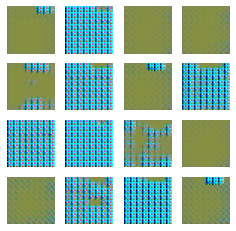

1000 [D loss supervised: 1.8548, acc.: 33.00%] [D loss unsupervised: 0.3146] [G loss: 9.481166]


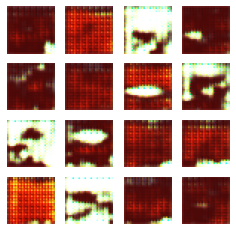

1500 [D loss supervised: 1.9225, acc.: 33.00%] [D loss unsupervised: 0.1023] [G loss: 14.582733]


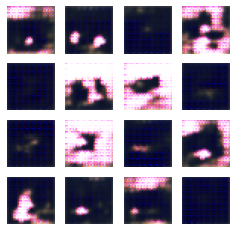

2000 [D loss supervised: 1.5260, acc.: 56.00%] [D loss unsupervised: 0.1912] [G loss: 12.267282]


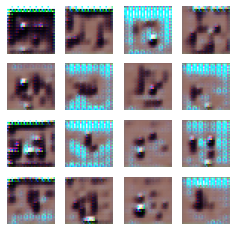

2500 [D loss supervised: 1.3999, acc.: 50.00%] [D loss unsupervised: 0.8920] [G loss: 7.769886]


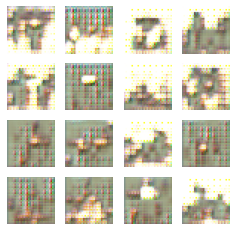

3000 [D loss supervised: 1.3794, acc.: 47.00%] [D loss unsupervised: 0.0129] [G loss: 13.592443]


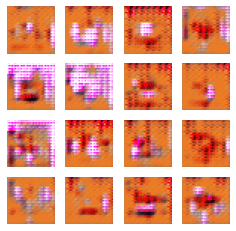

3500 [D loss supervised: 1.2114, acc.: 57.00%] [D loss unsupervised: 0.0326] [G loss: 12.714375]


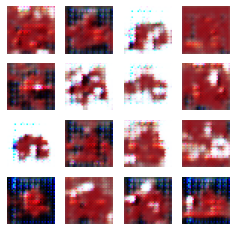

4000 [D loss supervised: 1.2017, acc.: 50.00%] [D loss unsupervised: 0.5515] [G loss: 4.396183]


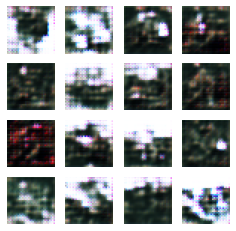

4500 [D loss supervised: 1.2369, acc.: 58.00%] [D loss unsupervised: 0.3027] [G loss: 6.169797]


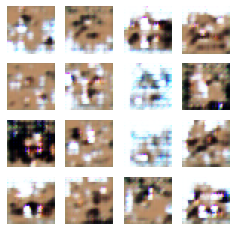

5000 [D loss supervised: 1.1783, acc.: 57.00%] [D loss unsupervised: 0.7747] [G loss: 8.904620]


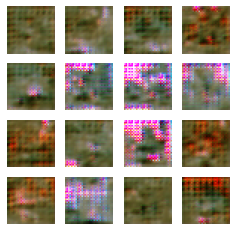

5500 [D loss supervised: 0.9755, acc.: 62.00%] [D loss unsupervised: 0.4678] [G loss: 5.363740]


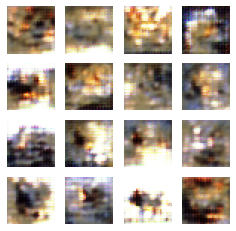

6000 [D loss supervised: 1.0316, acc.: 67.00%] [D loss unsupervised: 1.1180] [G loss: 5.171916]


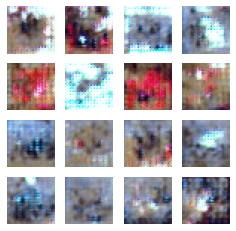

6500 [D loss supervised: 0.8766, acc.: 73.00%] [D loss unsupervised: 1.2812] [G loss: 4.200688]


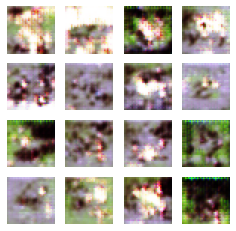

7000 [D loss supervised: 0.8403, acc.: 72.00%] [D loss unsupervised: 0.4049] [G loss: 2.597110]


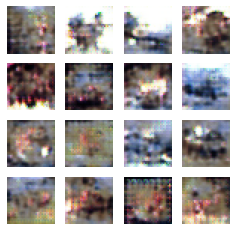

7500 [D loss supervised: 0.9531, acc.: 69.00%] [D loss unsupervised: 0.8192] [G loss: 5.775820]


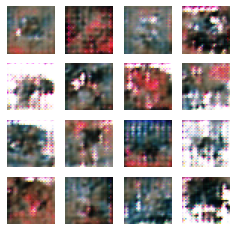

8000 [D loss supervised: 0.7524, acc.: 68.00%] [D loss unsupervised: 0.5682] [G loss: 2.410576]


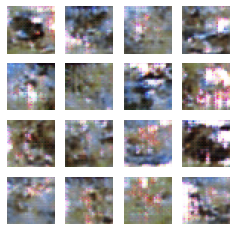

8500 [D loss supervised: 0.7333, acc.: 77.00%] [D loss unsupervised: 0.4940] [G loss: 3.749727]


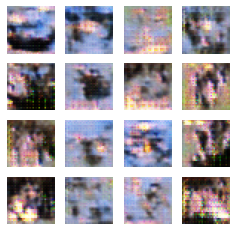

9000 [D loss supervised: 0.8090, acc.: 70.00%] [D loss unsupervised: 0.8875] [G loss: 4.474295]


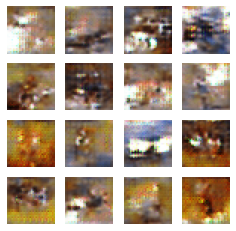

9500 [D loss supervised: 0.5836, acc.: 84.00%] [D loss unsupervised: 0.4289] [G loss: 2.422432]


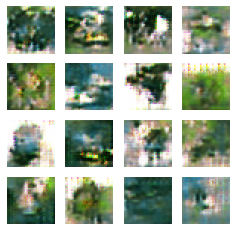

10000 [D loss supervised: 0.6900, acc.: 78.00%] [D loss unsupervised: 0.8764] [G loss: 3.310024]


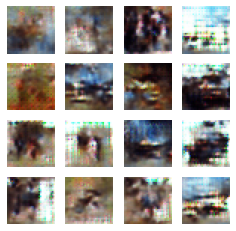

10500 [D loss supervised: 0.5241, acc.: 82.00%] [D loss unsupervised: 0.8609] [G loss: 4.334060]


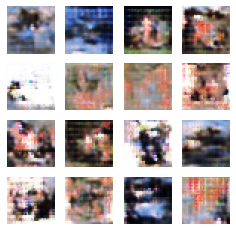

11000 [D loss supervised: 0.5043, acc.: 81.00%] [D loss unsupervised: 0.7305] [G loss: 2.790757]


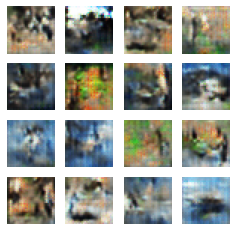

11500 [D loss supervised: 0.5091, acc.: 81.00%] [D loss unsupervised: 0.5223] [G loss: 2.439903]


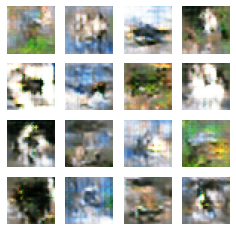

12000 [D loss supervised: 0.6026, acc.: 81.00%] [D loss unsupervised: 0.6949] [G loss: 3.266075]


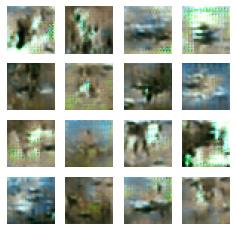

12500 [D loss supervised: 0.5257, acc.: 83.00%] [D loss unsupervised: 0.3537] [G loss: 2.911633]


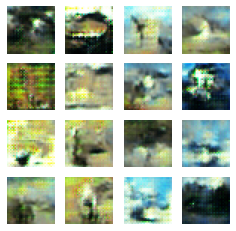

13000 [D loss supervised: 0.4427, acc.: 84.00%] [D loss unsupervised: 0.7029] [G loss: 3.377022]


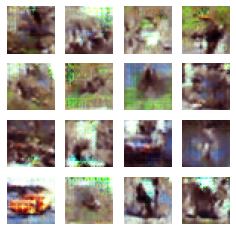

13500 [D loss supervised: 0.5542, acc.: 77.00%] [D loss unsupervised: 0.6559] [G loss: 2.667258]


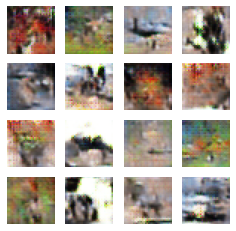

14000 [D loss supervised: 0.3977, acc.: 86.00%] [D loss unsupervised: 0.5601] [G loss: 2.785789]


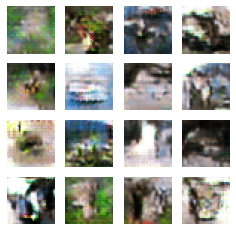

In [16]:
# 하이퍼파라미터를 셋팅합니다.
iterations = 14000
batch_size = 100
sample_interval = 500

# 지정한 반복 횟수 동안 SGAN을 훈련합니다.
train(iterations, batch_size, sample_interval)

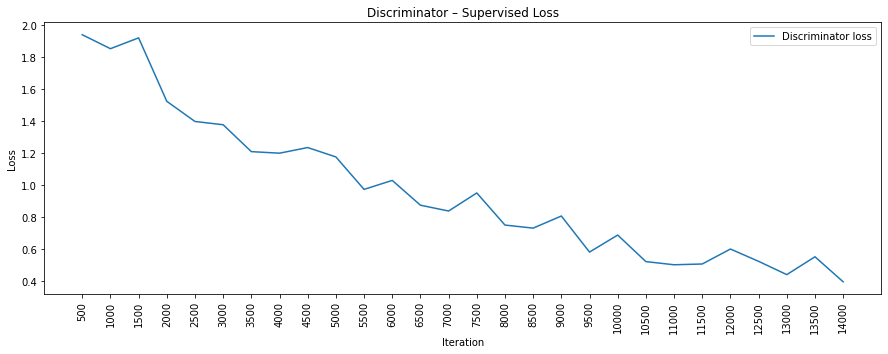

In [17]:
losses = np.array(supervised_losses)

# 판별자의 지도 학습 손실을 그립니다.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

## SGAN 분류기 – 훈련 세트와 테스트 세트 정확도

In [18]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

157/157 [==============================] - 1s 4ms/step - loss: 0.2205 - accuracy: 0.9666
Training Accuracy: 96.66%


In [19]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 1.2149 - accuracy: 0.5968
Test Accuracy: 59.68%


# 완전히 지도 학습으로 훈련된 분류기

In [20]:
# SGAN 판별자와 같은 네트워크 구조를 가진 지도 학습 분류기
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



In [21]:
imgs, labels = dataset.training_set()

# 레이블을 원-핫 인코딩합니다.
labels = to_categorical(labels, num_classes=num_classes)

# 분류기를 훈련합니다.
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
157/157 [==============================] - 2s 8ms/step - loss: 2.1573 - accuracy: 0.1872
Epoch 2/30
157/157 [==============================] - 2s 10ms/step - loss: 1.7290 - accuracy: 0.3842
Epoch 3/30
157/157 [==============================] - 1s 8ms/step - loss: 1.5517 - accuracy: 0.4321
Epoch 4/30
157/157 [==============================] - 1s 8ms/step - loss: 1.4823 - accuracy: 0.4586
Epoch 5/30
157/157 [==============================] - 2s 12ms/step - loss: 1.3489 - accuracy: 0.5189
Epoch 6/30
157/157 [==============================] - 2s 9ms/step - loss: 1.2445 - accuracy: 0.5405
Epoch 7/30
157/157 [==============================] - 1s 9ms/step - loss: 1.1246 - accuracy: 0.5973
Epoch 8/30
157/157 [==============================] - 2s 11ms/step - loss: 1.0315 - accuracy: 0.6381
Epoch 9/30
157/157 [==============================] - 1s 9ms/step - loss: 0.9535 - accuracy: 0.6469
Epoch 10/30
157/157 [==============================] - 1s 9ms/step - loss: 0.8712 - accuracy: 0.6

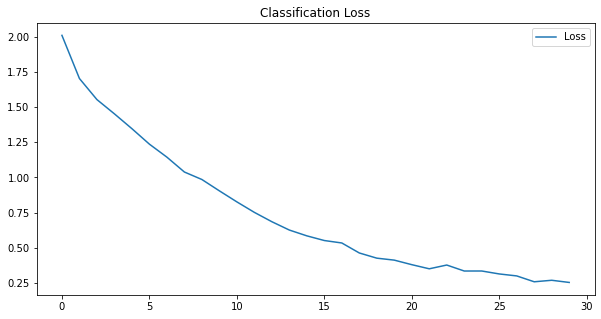

In [22]:
# 분류 손실을 그립니다
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()
plt.show()

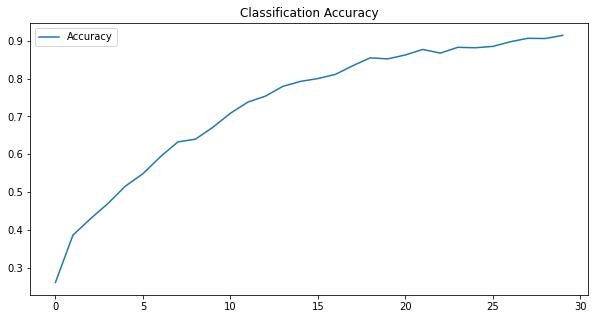

In [23]:
# 분류 정확도를 그립니다.
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()

In [24]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

157/157 [==============================] - 1s 3ms/step - loss: 0.0347 - accuracy: 0.9974
Training Accuracy: 99.74%


In [25]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 1.9456 - accuracy: 0.5410
Test Accuracy: 54.10%
